# Part I: Data Collection

### Data Initial Download


In [5]:
# https://github.com/jadchaar/sec-edgar-downloader
!pip install -U sec-edgar-downloader --user

  Using cached sec_edgar_downloader-4.2.2-py3-none-any.whl (13 kB)

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the 'C:\ProgramData\Anaconda3\python.exe -m pip install --upgrade pip' command.



  Using cached Faker-9.8.1-py3-none-any.whl (1.2 MB)
Processing c:\users\clair\appdata\local\pip\cache\wheels\0a\9e\ba\20e5bbc1afef3a491f0b3bb74d508f99403aabe76eda2167ca\bs4-0.0.1-py3-none-any.whl
  Using cached typing_extensions-3.10.0.2-py3-none-any.whl (26 kB)


In [6]:
from sec_edgar_downloader import Downloader
import pandas as pd

### Resources:
- S&P 500 tickers saved as **./Data/Tickers_SP500.csv** *(source: Wikipedia https://en.wikipedia.org/wiki/List_of_S%26P_500_companies)*
- All companies in EDGAR database saved as **./Data/company_tickers_exchange.json** *(source: SEC https://www.sec.gov/os/accessing-edgar-data/)* 
- All listed stock tickers on NYSE/NASDAQ/AMEX saved as **./Data/nasdaq_screener_ALL.csv** *(source: NASDAQ https://www.nasdaq.com/market-activity/stocks/screener)*


In [ ]:
path_data = "C:/Users/clair/Desktop/Thesis/masterThesis2022/Data/"
path_save = "D:/masterThesis2022/Data/"

# Initialize a downloader instance
dl = Downloader(path_save)

# Get tickers of S&P 500 companies
df_sp = pd.read_csv(path_data+"Tickers_SP500.csv")

# Downloading financial reports 
for ticker in df_sp["Symbol"]:
    dl.get('10-Q', ticker, amount=100) # only 3x 10Q per year + 1x 10K
    dl.get('10-K', ticker, amount=30) # ideally wanted 30 years (1990-2020)

# In EDGAR databse, most of the company's online files start in early 2000's / late 1990's. EDGAR was established in 1994/95.
# Downloading took c. 17 hours in total

### Statistic of Initial Download

In [ ]:
import os
path = path_save+"sec-edgar-filings/"

tickers = []
K_files =[]
Q_files=[]

for ticker in os.listdir(path):
    try:
        K = os.listdir(path+ticker+"/10-K/")
    except FileNotFoundError:
        K = []
    try:
        Q = os.listdir(path+ticker+"/10-Q/")
    except FileNotFoundError:
        Q = []
    tickers.append(ticker)
    K_files.append(K)
    Q_files.append(Q)

df = pd.DataFrame.from_dict({'ticker':tickers, '10K_files':K_files,'10Q_files':Q_files})

df['k_count'] = df['10K_files'].apply(len)
df['q_count'] = df['10Q_files'].apply(len)
df['total'] = df['k_count']+df['q_count']

df.set_index('ticker', inplace=True)

df.to_csv(path_data+"statistics.csv",index=True, index_label='ticker')


In [17]:
df.head()

,ticker,10K_files,10Q_files,k_count,q_count,total
0,MSFT,"['0001564590-21-039151', '0001564590-20-034944...","['0001564590-21-051992', '0001564590-21-020891...",21,62,83
1,AAPL,"['0000320193-21-000105', '0000320193-20-000096...","['0000320193-21-000065', '0000320193-21-000056...",21,64,85
2,GOOG,"['0001652044-21-000010', '0001652044-20-000008...","['0001652044-21-000057', '0001652044-21-000047...",6,19,25
3,AMZN,"['0001018724-21-000004', '0001018724-20-000004...","['0001018724-21-000028', '0001018724-21-000020...",18,64,82
4,TSLA,"['0001564590-21-004599', '0001564590-20-004475...","['0000950170-21-002253', '0000950170-21-000524...",11,35,46


In [13]:
import json

with open(path_data+'company_tickers_exchange.json') as file_json:
    json_data = json.load(file_json)

df_edgar = pd.DataFrame(json_data['data'],columns=json_data['fields'])
df_edgar.set_index('ticker', inplace=True)
df_edgar.head()

,cik,name,exchange
ticker,,,
MSFT,789019,MICROSOFT CORP,Nasdaq
AAPL,320193,Apple Inc.,Nasdaq
GOOG,1652044,Alphabet Inc.,Nasdaq
AMZN,1018724,AMAZON COM INC,Nasdaq
TSLA,1318605,"Tesla, Inc.",Nasdaq


In [14]:
df_sp = pd.read_csv(path_data+"Tickers_SP500.csv")
df_sp.set_index('Symbol', inplace=True)
df_sp.head() 

,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
Symbol,,,,,,,,
MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",8/9/1976,66740,1902
ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",3/31/1964,1800,1888
ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",12/31/2012,1551152,2013
ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",5/31/2018,815094,1981
ACN,Accenture,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",7/6/2011,1467373,1989


In [ ]:
# Create a master database with combined information from all data sources
df = pd.concat([df_edgar[['cik','name','exchange']],df], axis=1, join="inner") #add columns from edgar file
df = pd.concat([df, df_sp[['GICS Sector', 'GICS Sub-Industry','Date first added','Founded']]], axis=1, join="inner") # add columns from sp500 file

# Save
df.to_csv(path_save+"statistics.csv",index=True, index_label='ticker')


In [15]:
df.head()

,ticker,cik,name,exchange,10K_files,10Q_files,k_count,q_count,total,GICS Sector,GICS Sub-Industry,Date first added,Founded
0,MSFT,789019,MICROSOFT CORP,Nasdaq,"['0001564590-21-039151', '0001564590-20-034944...","['0001564590-21-051992', '0001564590-21-020891...",21,62,83,Information Technology,Systems Software,6/1/1994,1975
1,AAPL,320193,Apple Inc.,Nasdaq,"['0000320193-21-000105', '0000320193-20-000096...","['0000320193-21-000065', '0000320193-21-000056...",21,64,85,Information Technology,"Technology Hardware, Storage & Peripherals",11/30/1982,1977
2,GOOG,1652044,Alphabet Inc.,Nasdaq,"['0001652044-21-000010', '0001652044-20-000008...","['0001652044-21-000057', '0001652044-21-000047...",6,19,25,Communication Services,Interactive Media & Services,4/3/2006,1998
3,AMZN,1018724,AMAZON COM INC,Nasdaq,"['0001018724-21-000004', '0001018724-20-000004...","['0001018724-21-000028', '0001018724-21-000020...",18,64,82,Consumer Discretionary,Internet & Direct Marketing Retail,11/18/2005,1994
4,TSLA,1318605,"Tesla, Inc.",Nasdaq,"['0001564590-21-004599', '0001564590-20-004475...","['0000950170-21-002253', '0000950170-21-000524...",11,35,46,Consumer Discretionary,Automobile Manufacturers,12/21/2020,2003


In [18]:
df[['k_count','q_count','total']].describe()

,k_count,q_count,total
count,502.000000,502.000000,502.000000
mean,19.500000,60.774900,80.274900
std,6.769885,21.636609,28.180912
min,0.000000,1.000000,1.000000
25%,18.000000,59.000000,78.000000
50%,20.000000,62.000000,82.000000
75%,21.000000,64.000000,85.000000
max,30.000000,100.000000,130.000000


In [20]:
len(df.index[df['total']<80])

145

##### Observation:
A total of 145 companies (c. 30% of 500) have less than 80 reports; there are two categories:

- Company might have changed names/tickers, EDGAR only captures the latest (e.g. Google -> Alphabet in 2015)

- IPO dates after 2000 (NOT so easy to find historical IPO dates) - ASSUMING most companies with more than 40 reports belong to this category 


In [21]:
len(df.index[(df['total']<80)&(df['total']>40)])

# spot checks: Under-Armour, Discovery, Tesla... IPO between 2000 and 2010 makes sense!

88

In [29]:
len(df.index[(df['total']>30)&(df['total']<=40)])

# spot checks: paycom Software 31 2014; Twitter 32 2013; Hilton 32 2013; Norwegian Cruise 36, 2013; News Corp 32, 2013; Allegion 32, 2013

17

##### Observation:
- After performing spot checks, quite confident that most of the companies with total number of reports between 80 and 30 had their IPOs in between 2000 and 2013

In [30]:
len(df.index[(df['total']>20)&(df['total']<=30)]), len(df.index[(df['total']<=20)])

(16, 24)

##### Observation:

Information below is based on desktop research. 


**IPOs**
- Catalent, Inc. 2014; IHS 2014; 
- PayPal 2015; ETSY 2015; 
- Fortive Corp 2016; 
- Baker Hughes Co 2017 IPO; 
- Ceridian HCM Holding Inc. 2018;  Moderna, Inc 2018 IPO; 
- Viatris Inc 2020;

**M&As**
- Keysight Technology 2014 spin-off from Agilent Technologies
- CITIZENS FINANCIAL GROUP INC/RI 2014 carve-out of Royal Bank of Scotland

- Hewlett Packard Enterprise Co 2015 spin-off from HP
- Kraft Heinz 2015 merger
- Walgreens Boots Alliance 2015 merger
- WRK WestRock Co #12 - 2015 merger of MeadWestvaco and RockTenn

- DXC Technology Co  #19 - 2017 spin-off of Enterprise Service segment from Hewlett Packard Enterprise

- ViacomCBS Inc 2019 CBS acquisition of Viacom
- Amcor plc 2019 acquisition of Bemis Company Inc. and began trading on the NYSE under the ticker symbol “AMCR” and on the Australian Securities Exchange under the ticker “AMC.
- OGN Organon & Co. 2020 spin-off of Women’s Health, Legacy Brands and Biosimilars businesses from Merck & Co.

- DuPont de Nemours, Inc 2019 separation of its Agriculture Division through the spin-off of Corteva, Inc. (“Corteva”). The company was formerly known as DowDuPont Inc
- Corteva, Inc. 2019 #11 spin-off from DowDuPont;

- CARRIER GLOBAL Corp 2020 separation from United Technologies
- Otis Worldwide Corp 2020 separation from United Technologies
- (United Technology renamed RAYTHEON TECHNOLOGIES and already included in database under RTX, CIK #101829)

- Broadcom Inc. #14 - acquired by Avago Technologies in 2016; previously Broadcom Corp
- Cigna Corp #12 - acquired Express Scripts in 2018
- EVRG Evergy, Inc. #14 - merger of Great Plains Energy and Westar Energy, Inc. 2017
- CTRA Coterra Energy Inc. #11 - Cimarex, Cabot Complete Merger, Rebrand as Coterra Energy 2021
- 
- ***Companies with M&A activies have fewer reports in the EDGAR database because the CIK tickers only point to the current surviving entities; the former entities before the merger/spin-off need to be added separately.***
<br>

**Name Changes**
- Google changed its name in 2015 and SEC CIK has changed - current 0001652044; before 0001288776

- Lumen Technologies, Inc. #5: name change in 2020 from CenturyLink (NYSE:CTL) to Lumen Technologies (LUMN); same CIK could get all.

- BBWI Bath & Body Works, Inc. #1 name change in 2021from 'Victoria's Secretes' / 'L Brands’; symbol will also change from “LB” to “BBWI.”

**Tax Incorporation Changes**
- STERIS plc 1992 - 11; - incorporation changes from UK to Ireland

- Medtronic 27; - 2015 registration from US to Ireland, acquisition of Irish–tax registered Covidien (a U.S. tax inversion to Ireland from 2007)

**Others**
- NXP Semiconductors N.V 2011 - 9: switched to 10-Q and 10-F in 2019; before foreign issuer 20-F instead of 10-K; quarterly reports not required to file


In [33]:
df_sp.index.difference(df.index) #['BF.B':Brown-Forman Corporation Class B, 'BRK.B', 'FRC']

Index(['BF.B', 'BRK.B', 'FRC'], dtype='object', name='Symbol')

##### Observation
- BF.B: Brown-Forman Corp class B shares; known as BF in EDGAR
- BRK.B: Berkshire Hathaway class B share; known as BRK in EDGAR
- FRC: First republic bank (https://sec.report/Ticker/FRC) - financial reports seem to be missing from EDGAR


In [44]:
df['name'].size #502
df['name'].unique().size #497
df[df['name'].isin(df['name'][df['name'].duplicated()])].sort_values(by='name')

,ticker,cik,name,exchange,10K_files,10Q_files,k_count,q_count,total,GICS Sector,GICS Sub-Industry,Date first added,Founded
2,GOOG,1652044,Alphabet Inc.,Nasdaq,"['0001652044-21-000010', '0001652044-20-000008...","['0001652044-21-000057', '0001652044-21-000047...",6,19,25,Communication Services,Interactive Media & Services,4/3/2006,1998
497,GOOGL,1652044,Alphabet Inc.,Nasdaq,"['0001652044-21-000010', '0001652044-20-000008...","['0001652044-21-000057', '0001652044-21-000047...",6,19,25,Communication Services,Interactive Media & Services,4/3/2014,1998
436,DISCA,1437107,"Discovery, Inc.",Nasdaq,"['0001437107-21-000018', '0001437107-20-000006...","['0001437107-21-000183', '0001437107-21-000166...",13,40,53,Communication Services,Broadcasting,3/1/2010,1985
500,DISCK,1437107,"Discovery, Inc.",Nasdaq,"['0001437107-21-000018', '0001437107-20-000006...","['0001437107-21-000183', '0001437107-21-000166...",13,40,53,Communication Services,Broadcasting,8/7/2014,1985
321,FOXA,1754301,Fox Corp,Nasdaq,"['0001564590-21-043103', '0001564590-20-038975...","['0001628280-21-021531', '0001564590-21-024240...",3,9,12,Communication Services,Movies & Entertainment,7/1/2013,2019
498,FOX,1754301,Fox Corp,Nasdaq,"['0001564590-21-043103', '0001424929-21-000014...","['0001424929-21-000132', '0001628280-21-021531...",30,100,130,Communication Services,Movies & Entertainment,9/18/2015,2019
430,NWSA,1564708,NEWS CORP,Nasdaq,"['0001564708-21-000029', '0001564708-20-000022...","['0001564708-21-000040', '0001564708-21-000023...",9,23,32,Communication Services,Publishing,8/1/2013,2013
499,NWS,1564708,NEWS CORP,Nasdaq,"['0001564708-21-000029', '0001564708-20-000022...","['0001564708-21-000040', '0001564708-21-000023...",9,23,32,Communication Services,Publishing,9/18/2015,2013
466,UA,1336917,"Under Armour, Inc.",NYSE,"['0001336917-21-000009', '0001336917-20-000010...","['0001336917-21-000063', '0001336917-21-000040...",20,59,79,Consumer Discretionary,"Apparel, Accessories & Luxury Goods",4/8/2016,1996
501,UAA,1336917,"Under Armour, Inc.",NYSE,"['0001336917-21-000009', '0001336917-20-000010...","['0001336917-21-000063', '0001336917-21-000040...",16,45,61,Consumer Discretionary,"Apparel, Accessories & Luxury Goods",5/1/2014,1996


In [50]:
# Deleting duplicates selectively

df.drop(['GOOGL','DISCA','FOXA','NWSA','UAA'], axis='index', inplace=True)

df.to_csv(path_data+"statistics_v1.csv",index=True, index_label='ticker')


##### Additional Notes:

- Some repeats are due to difference classes of share with different voting rights, but essentially same underlying operating entities and therefore same financial reports (evidenced by the same CIK numbers)
> - GOOG / GOOGL represent different classes of shares but same operating entity; IPO 2004
> - DISCK / DISKCA difference classes of shares, same operating entity therefore same reports
> - UA / UAA: The ticker "UA" represents Class C shares, while "UAA" represents Class A voting shares
> - NWSA / NWS: News Corp Class A and Class B Common Stock under the ticker symbols “NWSA” and “NWS,” respectively

- The M&A history amongst News Corp / Fox Corp / Disney:
> - The current News Corp began trading on the NASDAQ stock exchange under the symbol "NWS" on July 1, 2013; at the same time, the former News Corporation (which encompassed purely of media properties, such as Fox Entertainment Group and 20th Century Fox) was renamed 21st Century Fox.
>- Walt Disney Co 1957 #10 - 2019 acquisition of Twenty-First Century Fox, Inc.
>- 21 Centry Fox 2013 - 2019 sell to Walt Disney; remaining Fox Corp
>- Fox Corp 2019 - Fox Corp represents the assets not sold to Disney by the predecessor firm, Twenty First Century Fox. The remaining assets include Fox News, the FOX broadcast network, FS1 and FS2, Fox Business, Big Ten Network, 28 owned and operated local television stations of which 17 are affiliated with the Fox Network, and the Fox Studios lot. The Murdoch family continues to control the successor firm


### Supplementary Data Download
Based on the above observations and background research, the following amends are needed:

- Use corrected tickers (i.e. remove xxx.B which is not recognized in EDGAR)
- Identity CIKs for entities before name / tax incorporating changes
- Find CIKs for former entities before M&A / spin-off
- Download 20-F for foreign issuer NXPI

The 2nd batch of downloads are saved in a separate location for further processing, i.e. manually merging into the right folders in the master database.

In [ ]:
dl = Downloader(path_data)

# Group 1 - amended tickers, name change, tax incorporationg change
addn1 = {'BF':'BROWN FORMAN CORP',
        'BRK':'BERKSHIRE HATHAWAY INC',

        'LB':'BBWI - Bath & Body Works name change from L Brands in 2021 ',
        '1288776': 'GOOG - Alphabet name change from Google Inc. in 2015',
        '18926':'LUMN - Lumen Technologies name change from CenturyLink in 2020',

        '1624899':'STE - STERIS plc 2015-19 before HQ change from UK to Ireland', '815065':'STE - STERIS Corp 1999-2015',
        '64670':'MDT - Medtronic plc HQ change from US to Ireland in 2014; Medtronic Inc 1999-2015 before tax inversion',
        }

for ticker in addn1.keys():
    dl.get('10-Q', ticker, amount=100) # only 3x 10Q per year + 10K
    dl.get('10-K', ticker, amount=30) # ideally wanted 30 years (1990-2020)



# Group 2 - former entities before M&A/spin-off

addn2 = {'54507':'EVRG - Westar Energy (WR) before merger 2017 (containing latest)', '1143068':'EVRG - Great Plains Energy Inc before merger 2017',
         '701221': 'CI - CIGNA Holding Co 2004-2018 before acquiring the pharmacy services company Express Scripts in 2018', '1532063':'Express Scripts before acquisition by Cigna 2011-2018; IPO 2011',
         '1649338':'AVGO - Broadcom Pte. Ltd. merged entity 2016-18','1054374':'Broadcom Corp before acquisition by Avago Technologies 1999-2015', '1441634':'Avago Technologies LTD before the acquisition of Broadcom 2009-2015',
         '858470':'CTRA - Cabot Oil & Gas Corp before merger in 2021 (containing latest)', '1168054':'CTRA - Cimarex Energy before merger 2021',
         '1545158':'KHC - Kraft Foods Group IPO 2011-2015 merger with Heinz', '46640':'KHC - H.J. Heinz 1994 - 2013 Take private',
         '104207':'WBA - Walgreens Co 1994-2015 delisting merger with Boots',
         '11199':'AMCR - Bemis Company, Inc. (NYSE: BMS) 1994 - 2019 acquisition by Amcor',
        '813828':'VIAC - CBS Corp 2007-2021 merger 2019 (containing latest)',
         '1339947':'VIAC - Viacom Inc 2005-2019 before merger with CBS in 2019',
         '1001039':'DIS - Walt Disney Co 2001-2020 before acquisition of 21st Century Fox',
        '1308161':'NWS - NewsCorp/Fox - 21st Century Fox / News Corp 2006 - 2019 before acquisition by Walt Disney',
}


for ticker in addn2.keys():
    dl.get('10-Q', ticker, amount=100) # only 3x 10Q per year + 10K
    dl.get('10-K', ticker, amount=30) # ideally wanted 30 years (1990-2020)


# Foreign Issuer 20F instead of 10K; quarterly reports are not required and sometimes are embedded in 6K
dl.get('20-F', 'NXPI') #8


### Statistic of Additional Download

In [ ]:
# Process additional downloads

path = path_data+"sec-edgar-filings/"

tickers = []
ciks = []
names =[]
K_files =[]
Q_files=[]

for ticker in os.listdir(path):
    try:
        K = os.listdir(path+ticker+"/10-K/")
    except FileNotFoundError:
        K = []
    try:
        Q = os.listdir(path+ticker+"/10-Q/")
    except FileNotFoundError:
        Q = []

    # Based on manually modified naming convension: Ticker_Name_CIK
    i = ticker.find('-')
    tickers.append(ticker[:i])

    j = ticker.rfind('_')
    ciks.append(ticker[j+1:])

    if i !=j:
        names.append(ticker[i+1:j])
    else:
        names.append('.')

    K_files.append(K)
    Q_files.append(Q)


df_addn = pd.DataFrame.from_dict({'ticker':tickers,'cik':ciks, 'name':names, '10K_files':K_files,'10Q_files':Q_files})
df_addn['k_count'] = df_addn['10K_files'].apply(len)
df_addn['q_count'] = df_addn['10Q_files'].apply(len)
df_addn['total'] = df_addn['k_count']+df_addn['q_count']

df_addn.set_index('ticker', inplace=True)
df_addn.to_csv(path_data+"statistics_v2.csv",index=True, index_label='ticker')

In [59]:
df_addn = pd.read_csv(path_data+"statistics_v2.csv", index_col='ticker')
df_addn.head()

,cik,name,10K_files,10Q_files,k_count,q_count,total
ticker,,,,,,,
AMCR,11199,Bemis Company,"['0000011199-13-000011', '0000011199-14-000006...","['0000011199-12-000011', '0000011199-13-000018...",17,55,72
AVGO,1441634,Avago Technologies,"['0000950123-10-113875', '0001193125-09-253349...","['0000950123-11-023882', '0000950123-11-057877...",7,19,26
AVGO,1054374,Broadcom Corp,"['0000892569-02-000531', '0000892569-03-000851...","['0000892569-01-500702', '0000892569-01-501081...",14,45,59
AVGO,1649338,Broadcom Merged,"['0001649338-16-000151', '0001649338-17-000158']","['0001649338-16-000019', '0001649338-16-000088...",2,7,9
BF,14693,.,"['0000014693-21-000091', '0001104659-21-086265...","['0000014693-21-000158', '0000943440-08-000372...",3,8,11


In [60]:
df_addn[['k_count','q_count','total']].describe()

,k_count,q_count,total
count,26.000000,26.000000,26.000000
mean,13.461538,40.461538,53.923077
std,7.489891,21.513216,28.751241
min,0.000000,0.000000,0.000000
25%,8.250000,23.000000,31.250000
50%,14.000000,43.500000,58.000000
75%,17.750000,55.750000,72.750000
max,30.000000,79.000000,106.000000


### Combined Data Overview 

In [64]:
df_combined = pd.concat([df,df_addn], axis=0, join="outer")

print("Number of companies in initial downloads:",len(df),
      "\nNumber of companies in additional downloads:",len(df_addn),
      "\nSubtotal in combined dataset:",len(df_combined), 
      "\nTotal Number of unique companies in dataset:", len(df_combined.index.unique()))

Number of companies in initial downloads (excl. repeats): 497 
Number of companies in additional downloads: 26 
Subtotal in combined dataset: 523 
Total Number of unique companies in dataset: 500


In [67]:
df_combined[['name','cik']][df_combined.index.duplicated()]

,name,cik
ticker,,
AMCR,Bemis Company,11199
AVGO,Avago Technologies,1441634
AVGO,Broadcom Corp,1054374
AVGO,Broadcom Merged,1649338
CI,CIGNA,701221
CI,Express Scripts,1532063
CTRA,Cabot Oil Gas Corp,858470
CTRA,Cimarex Energy,1168054
DIS,Walt Disney Co,1001039


In [69]:
df_summary = df_combined.groupby(level=0)['total'].sum()
df_summary.describe()

count    500.000000
mean      83.034000
std       26.439723
min        1.000000
25%       79.000000
50%       83.000000
75%       86.250000
max      166.000000
Name: total, dtype: float64

<AxesSubplot:ylabel='Frequency'>

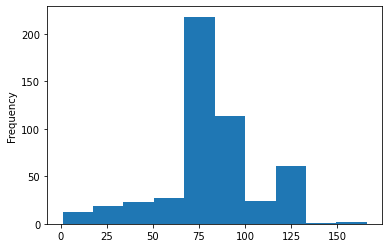

In [71]:
df_summary.plot.hist(bins=10)

GICS Sector
Industrials               74
Information Technology    74
Health Care               64
Financials                63
Consumer Discretionary    62
Consumer Staples          31
Real Estate               29
Materials                 28
Utilities                 28
Communication Services    23
Energy                    21
Name: name, dtype: int64


<AxesSubplot:ylabel='name'>

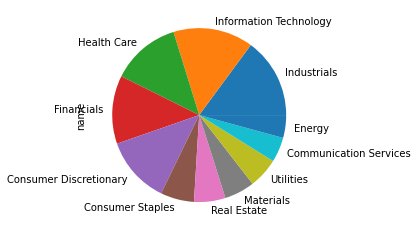

In [90]:
by_sector = df_combined.groupby('GICS Sector').count()['name'].copy()
by_sector.sort_values(ascending=False, inplace=True)
print(by_sector)

by_sector.plot.pie()


In [95]:
IT_subsector = df_combined[df_combined['GICS Sector']=='Information Technology'].groupby('GICS Sub-Industry').count()['name'].copy()
IT_subsector.sort_values(ascending=False, inplace=True)
print(IT_subsector)


GICS Sub-Industry
Application Software                          14
Semiconductors                                14
Data Processing & Outsourced Services         12
Technology Hardware, Storage & Peripherals     6
Communications Equipment                       5
IT Consulting & Other Services                 5
Semiconductor Equipment                        4
Electronic Components                          3
Electronic Equipment & Instruments             3
Systems Software                               3
Electronic Manufacturing Services              2
Internet Services & Infrastructure             2
Technology Distributors                        1
Name: name, dtype: int64


### Sampling for EDA

Take a sample of 50 companies for Exploratary Data Analysis
 - 40 from the Information Technology subsectors: Application Software (#14), Semiconductors (#14), Data Processing & Outsourced Services (#12)
 - 10 from the rest of the sectors randomly
 

In [102]:
samples1 = df_combined[df_combined['GICS Sub-Industry'].isin(['Application Software','Semiconductors','Data Processing & Outsourced Services'])]

samples1.to_csv(path_data+"statistics_samples1.csv",index=True, index_label='ticker')

samples1[['name','exchange','k_count','q_count','total','GICS Sector','GICS Sub-Industry']]


,name,exchange,k_count,q_count,total,GICS Sector,GICS Sub-Industry
ticker,,,,,,,
V,VISA INC.,NYSE,30,100,130,Information Technology,Data Processing & Outsourced Services
MA,Mastercard Inc,NYSE,30,100,130,Information Technology,Data Processing & Outsourced Services
ADBE,ADOBE INC.,Nasdaq,21,65,86,Information Technology,Application Software
CRM,"SALESFORCE.COM, INC.",NYSE,21,64,85,Information Technology,Application Software
ORCL,ORACLE CORP,NYSE,16,47,63,Information Technology,Application Software
PYPL,"PayPal Holdings, Inc.",Nasdaq,6,20,26,Information Technology,Data Processing & Outsourced Services
AVGO,Broadcom Inc.,Nasdaq,3,11,14,Information Technology,Semiconductors
INTC,INTEL CORP,Nasdaq,21,63,84,Information Technology,Semiconductors
QCOM,QUALCOMM INC/DE,Nasdaq,21,64,85,Information Technology,Semiconductors


In [105]:
samples2 = df_combined[df_combined['GICS Sub-Industry']!='Information Technology'].sample(10)

samples2.to_csv(path_data+"statistics_samples2.csv",index=True, index_label='ticker')

samples2[['name','exchange','k_count','q_count','total','GICS Sector']]


,name,exchange,k_count,q_count,total,GICS Sector
ticker,,,,,,
OGN,Organon & Co.,NYSE,0,2,2,Health Care
NI,NISOURCE INC.,NYSE,23,76,99,Utilities
GIS,GENERAL MILLS INC,NYSE,19,62,81,Consumer Staples
D,"DOMINION ENERGY, INC",NYSE,30,100,130,Utilities
GL,GLOBE LIFE INC.,NYSE,20,63,83,Financials
IEX,IDEX CORP /DE/,NYSE,18,64,82,Industrials
GOOG,Alphabet Inc.,Nasdaq,6,19,25,Communication Services
SIVB,SVB FINANCIAL GROUP,Nasdaq,21,64,85,Financials
YUM,YUM BRANDS INC,NYSE,25,79,104,Consumer Discretionary


In [106]:
df_combined.to_csv(path_data+"statistics_combined.csv",index=True, index_label='ticker')